In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds

dataset, info = tfds.load('kmnist', with_info=True, as_supervised=True)

full_dataset = dataset['train']

def preprocess_data(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

images, labels = preprocess_data(full_dataset)

# Normalize images to range [0, 1]
images = images.reshape(-1, 28*28) / 255.0

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}')

Training set shape: (48000, 784), Training labels shape: (48000,)
Test set shape: (12000, 784), Test labels shape: (12000,)


In [8]:
def rbf(x, center, sigma=1.0):
    return np.exp(-np.linalg.norm(x - center) ** 2 / (2 * sigma ** 2))

class RBFNetwork:
    def __init__(self, num_rbf_units, num_classes):
        self.num_rbf_units = num_rbf_units
        self.num_classes = num_classes
        self.centers = None
        self.weights = None
        self.sigma = None

    def fit(self, X, y, learning_rate=0.01, epochs=100):
        kmeans = KMeans(n_clusters=self.num_rbf_units)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Initialize weights randomly
        self.weights = np.random.randn(self.num_rbf_units, self.num_classes)

        # Using mean distance between centers as sigma
        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.sigma = d_max / np.sqrt(2 * self.num_rbf_units)

        # One-hot encode labels
        y_one_hot = np.eye(self.num_classes)[y]

        # Training loop
        for epoch in range(epochs):
            # Compute RBF activations for each input
            G = np.zeros((X.shape[0], self.num_rbf_units))
            for i, x in enumerate(X):
                for j, c in enumerate(self.centers):
                    G[i, j] = rbf(x, c, self.sigma)

            # Forward pass (softmax)
            output = self.softmax(np.dot(G, self.weights))

            # Backpropagation (gradient descent)
            error = output - y_one_hot
            self.weights -= learning_rate * np.dot(G.T, error)

            loss = np.mean(np.square(error))
            print(f'Epoch {epoch}\n\tLoss: {loss}')

    # Predict function
    def predict(self, X):
        G = np.zeros((X.shape[0], self.num_rbf_units))
        for i, x in enumerate(X):
            for j, c in enumerate(self.centers):
                G[i, j] = rbf(x, c, self.sigma)

        output = self.softmax(np.dot(G, self.weights))
        return np.argmax(output, axis=1)

    # Softmax function
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


In [11]:
# Instantiate the RBF Network
num_rbf_units = 100
num_classes = 10
rbf_network = RBFNetwork(num_rbf_units=num_rbf_units, num_classes=num_classes)

# Train the model
rbf_network.fit(X_train, y_train, learning_rate=0.01, epochs=100)


Epoch 0
	Loss: 0.0899999950438906
Epoch 1
	Loss: 0.08999999504219484
Epoch 2
	Loss: 0.08999999504049917
Epoch 3
	Loss: 0.08999999503880346
Epoch 4
	Loss: 0.08999999503710769
Epoch 5
	Loss: 0.08999999503541196
Epoch 6
	Loss: 0.08999999503371625
Epoch 7
	Loss: 0.08999999503202054
Epoch 8
	Loss: 0.08999999503032481
Epoch 9
	Loss: 0.08999999502862908
Epoch 10
	Loss: 0.08999999502693337
Epoch 11
	Loss: 0.08999999502523763
Epoch 12
	Loss: 0.08999999502354192
Epoch 13
	Loss: 0.08999999502184619
Epoch 14
	Loss: 0.0899999950201505
Epoch 15
	Loss: 0.08999999501845476
Epoch 16
	Loss: 0.08999999501675904
Epoch 17
	Loss: 0.08999999501506331
Epoch 18
	Loss: 0.08999999501336757
Epoch 19
	Loss: 0.0899999950116719
Epoch 20
	Loss: 0.08999999500997616
Epoch 21
	Loss: 0.08999999500828038
Epoch 22
	Loss: 0.08999999500658468
Epoch 23
	Loss: 0.08999999500488898
Epoch 24
	Loss: 0.08999999500319322
Epoch 25
	Loss: 0.08999999500149755
Epoch 26
	Loss: 0.08999999499980177
Epoch 27
	Loss: 0.08999999499810604
Epoch

Accuracy: 7.41%


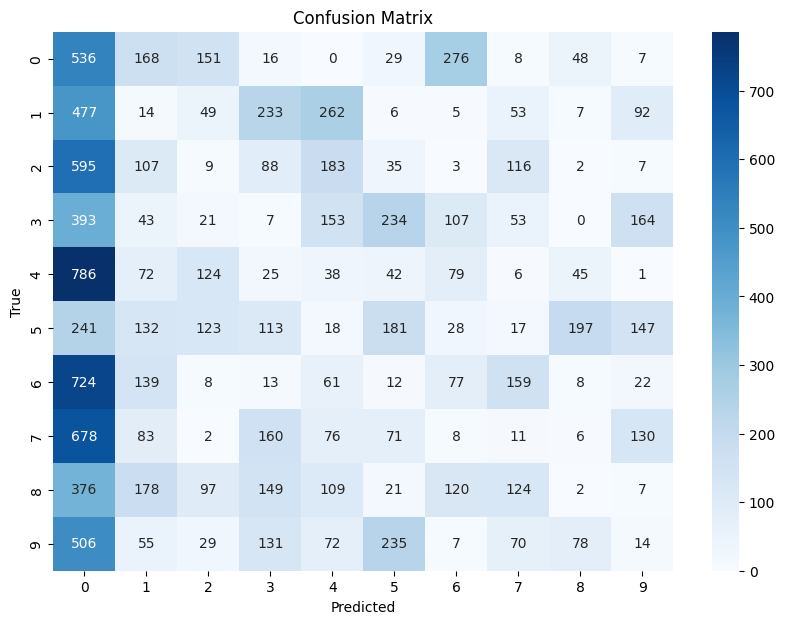

In [12]:
y_pred = rbf_network.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


- Very Low Accuracy:  An accuracy of 7.19% is extremely low. It essentially means the model is performing no better than random guessing. If there were 10 classes (as is likely with Kuzushiji-MNIST), random guessing would yield about 10% accuracy.
- Model Issues:  The RBF network, as implemented, is struggling to learn the complex patterns in the Kuzushiji-MNIST dataset. This indicates potential problems with the model's architecture, training process, or hyperparameter settings.
- The loss remains same at around 0.899, which means that :
  - Early convergence: The model reached its best performance quickly.
  - Possible local minimum: The model may be stuck at a suboptimal point.
  - Inadequate learning rate: 0.01 might be too small for meaningful updates.
  - Limited model capacity: The model may be too simple for the problem.
  - Data or problem constraints: Further improvement might be inherently difficult.
  - Good initialization: Starting parameters may have been coincidentally effective.
  - Optimization limitations: The current algorithm may be ineffective for this problem.
---
## Discuss the strengths and limitations of using an RBF network for this (kmnist) dataset.

- Strengths of RBF networks for kmnist:

  - Good at modeling non-linear relationships in data
  - Can focus on specific local features of characters
  - Often train faster than some other neural networks
  - More interpretable results
  - Can handle outliers well

- Limitations:

  - May struggle with high-dimensional data (kmnist images are 784 dimensions)
  - Choosing good center points is challenging but crucial
  - Fixed structure limits adaptability
  - May not scale well to large datasets like kmnist (70,000 images)
  - Lacks built-in feature extraction, unlike CNNs
  - Might not generalize well to unseen character variations
  - Can be memory-intensive
  ---
  ## How does the number of RBF units affect model performance?
  